# Evolutionary Algorithm - Evolving Mona Lisa using Lines
## Each individual is a set of colored lines drawn over a canvas
## Goal: Approximate Mona Lisa image

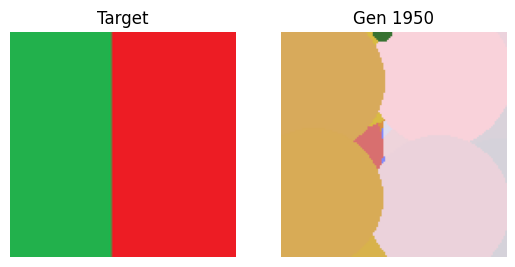

✅ Evolution complete!


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import clear_output
import random
from skimage.metrics import structural_similarity as ssim


# ==== CONFIGURATION ====
TARGET_PATH = "red-green.bmp"  # <-- replace with your own small image
NUM_CIRCLES = 50            # number of circles per individual
POP_SIZE = 50               # number of individuals per generation
GENERATIONS = 2000          # how many generations to evolve
MUTATION_RATE = 0.1
IMG_SIZE = (128, 128)       # target image size (resized for performance)
DISPLAY_INTERVAL = 50       # show every N generations


# ==== LOAD AND PREPARE TARGET IMAGE ====
target_img = Image.open(TARGET_PATH).convert("RGB").resize(IMG_SIZE)
target_array = np.array(target_img, dtype=np.int16)


# ==== HELPER FUNCTIONS ====
def random_circle():
    """Generate a random circle (x, y, radius, color, alpha)."""
    return {
        "x": random.randint(0, IMG_SIZE[0]),
        "y": random.randint(0, IMG_SIZE[1]),
        "r": random.randint(5, 30),
        "color": tuple(np.random.randint(0, 256, 4)),
    }

def draw_individual(genes):
    """Render the genes (circles) into an image."""
    img = Image.new("RGB", IMG_SIZE, (255, 255, 255))
    overlay = Image.new("RGBA", IMG_SIZE, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay, "RGBA")
    for g in genes:
        color = g["color"]
        draw.ellipse(
            [g["x"] - g["r"], g["y"] - g["r"], g["x"] + g["r"], g["y"] + g["r"]],
            fill=color
        )
    img = Image.alpha_composite(img.convert("RGBA"), overlay)
    return img.convert("RGB")

def fitness(genes):
    """Compute fitness as negative mean squared error (higher is better)."""
    img = np.array(draw_individual(genes), dtype=np.int16)
    mse = np.mean((img - target_array) ** 2)
    return -mse


def fitness_2(genes):
    """
    SSIM (Structural Similarity Index) is advantageous because it measures image similarity in a way that aligns 
    with human perception, taking into account luminance, contrast, and structural patterns rather than just raw 
    pixel differences. Unlike simple metrics like MSE, SSIM rewards the correct formation of shapes and textures, 
    is more robust to small brightness or contrast changes, and provides a smooth, bounded score that guides 
    genetic algorithms toward visually meaningful solutions. This makes it ideal for image evolution tasks, as 
    it encourages the algorithm to produce images that look right rather than merely match pixel values.
    """
    # Render the individual into an image
    img = np.array(draw_individual(genes), dtype=np.uint8)

    # Convert both images to grayscale
    gray_target = np.dot(target_array[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

    # Compute SSIM (returns value between -1 and 1, higher = better)
    ssim_score = ssim(gray_target, gray_img)

    return ssim_score  # higher is better

    
def mutate(genes):
    """Mutate by changing one or more circles slightly."""
    new_genes = [g.copy() for g in genes]
    for g in new_genes:
        if random.random() < MUTATION_RATE:
            g["x"] = np.clip(g["x"] + random.randint(-10, 10), 0, IMG_SIZE[0])
            g["y"] = np.clip(g["y"] + random.randint(-10, 10), 0, IMG_SIZE[1])
            g["r"] = np.clip(g["r"] + random.randint(-5, 5), 5, 40)
            g["color"] = tuple(np.clip(np.array(g["color"]) + np.random.randint(-20, 20, 4), 0, 255))
    return new_genes

def crossover(p1, p2):
    """Combine genes from two parents."""
    pivot = random.randint(0, NUM_CIRCLES)
    return p1[:pivot] + p2[pivot:]

def random_individual():
    return [random_circle() for _ in range(NUM_CIRCLES)]

# ==== INITIAL POPULATION ====
population = [random_individual() for _ in range(POP_SIZE)]
fitnesses = [fitness(ind) for ind in population]

best = population[np.argmax(fitnesses)]
best_score = max(fitnesses)

# ==== EVOLUTION LOOP ====
plt.figure(figsize=(6, 3))
for gen in range(GENERATIONS):
    # Selection (top 20%)
    sorted_pop = [x for _, x in sorted(zip(fitnesses, population), key=lambda z: z[0], reverse=True)]
    elites = sorted_pop[:POP_SIZE // 5]

    # Reproduction
    new_pop = elites.copy()
    while len(new_pop) < POP_SIZE:
        p1, p2 = random.sample(elites, 2)
        child = mutate(crossover(p1, p2))
        new_pop.append(child)

    population = new_pop
    fitnesses = [fitness(ind) for ind in population]
    current_best = population[np.argmax(fitnesses)]
    current_score = max(fitnesses)

    if current_score > best_score:
        best, best_score = current_best, current_score

    # === Display progress ===
    if gen % DISPLAY_INTERVAL == 0:
        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.title("Target")
        plt.imshow(target_img)
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.title(f"Gen {gen}")
        plt.imshow(draw_individual(best))
        plt.axis("off")
        plt.show()

print("✅ Evolution complete!")
